In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly


Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/


In [ ]:
import torch

In [ ]:
print(f"Number of GPUs: {torch.cuda.device_count()}")
print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

torch_ver = [int(x) for x in torch.__version__.split(".")[:2]]
assert torch_ver >= [2, 0], "Requires PyTorch >= 2.0"
print("PyTorch Version:", torch.__version__)

Number of GPUs: 1
['Tesla T4']
PyTorch Version: 2.5.0+cu121


### Helper function to measure the execution time for a given function

In [ ]:
import time
def timed(fn, n_test: int, dtype: torch.dtype) -> tuple:
    """
    Measure the execution time for a given function.

    Args:
    - fn (function): The function to be timed.
    - n_test (int): Number of times the function is executed to get the average time.
    - dtype (torch.dtype): Data type for PyTorch tensors.

    Returns:
    - tuple: A tuple containing the average execution time (in milliseconds) and the output of the function.
    """
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=dtype):
        dt_loop_sum = []
        for _ in range(n_test):
            torch.cuda.synchronize()
            start = time.time()
            output = fn()
            torch.cuda.synchronize()
            end = time.time()
            dt_loop_sum.append(end-start)
        dt_test = sum(dt_loop_sum) / len(dt_loop_sum)

    return dt_test * 1000, output

### Now let's look at the list of backends available

In [ ]:
torch.compiler.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

-------------------------------------------------------------------



# Let's begin with a simple Resnet Model

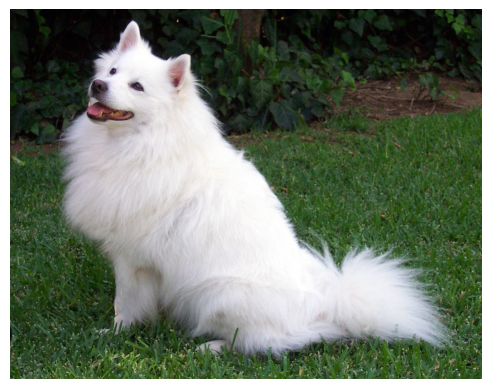

In [ ]:
# Download an example image from the pytorch website
import urllib
import matplotlib.pyplot as plt
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
input_image = Image.open(filename)
plt.imshow(input_image)
plt.axis('off')
plt.show()

In [ ]:
## Some preprocessing

import torch
import torchvision.transforms as transforms

# create the image preprocessor
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# load the resnet152 model
model = torch.hub.load('pytorch/vision:v0.17.2', 'resnet152', pretrained=True)
model.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output.shape)

Downloading: "https://github.com/pytorch/vision/zipball/v0.17.2" to /root/.cache/torch/hub/v0.17.2.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 159MB/s]


torch.Size([1, 1000])


In [ ]:
## Helper function to get the topk labels based on probabilities
def print_topk_labels(output, k):
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    topk_prob, topk_catid = torch.topk(probabilities, k)
    for i in range(topk_prob.size(0)):
        print(categories[topk_catid[i]], topk_prob[i].item())

# Download the Imagenet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-10-24 03:50:17--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2024-10-24 03:50:17 (19.7 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
## So, what are the topk Labels?
print_topk_labels(output, 5)


Samoyed 0.7907484173774719
Pomeranian 0.08977653086185455
white wolf 0.03610274940729141
keeshond 0.026814348995685577
Arctic fox 0.022788120433688164


## Performance Evaluation in Eager Mode

In [ ]:
n_warmup = 10
n_test = 20
dtype = torch.bfloat16
inference_time=[]
mode=[]

# In general, it's always recommended to warm-up the GPUs with some iterations
# before benchmarking the application
t_warmup, _ = timed(lambda:model(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model(input_batch), n_test, dtype)
print(f"Average inference time for resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("eager")

Average inference time for resnet152(warmup): dt_test=74.45104122161865 ms
Average inference time for resnet152(test): dt_test=35.335707664489746 ms
Samoyed 0.796875
Pomeranian 0.083984375
white wolf 0.037353515625
keeshond 0.025634765625
Arctic fox 0.021240234375


We run the GPU for 10 iterations followed by 20 iterations.

## Performance Evaluation in `torch.compile` Mode

### Default Mode

In [ ]:
# need to reset to make sure there's no compiled remains
torch._dynamo.reset()
model_opt1 = torch.compile(model, fullgraph=True)
t_compilation, _ = timed(lambda:model_opt1(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt1(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt1(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("default")

/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Compilation time: dt_compilation=45972.96953201294 ms
Average inference time for compiled resnet152(warmup): dt_test=40.27864933013916 ms
Average inference time for compiled resnet152(test): dt_test=31.566286087036133 ms
Samoyed 0.796875
Pomeranian 0.083984375
white wolf 0.037353515625
keeshond 0.025634765625
Arctic fox 0.021240234375


### Reduce-Overhead Mode

Leverages CUDA graphs to reduce the launch overheads of kernels.
Every Kernel Launch imposes a significant overhead on the overall
execution time of the model. By compiling them to CUDA Graphs, we
can reduce that overhead

In [ ]:
torch._dynamo.reset()
model_opt2 = torch.compile(model, mode="reduce-overhead", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt2(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt2(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt2(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("reduce-overhead")

/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Compilation time: dt_compilation=40412.38236427307 ms
Average inference time for compiled resnet152(warmup): dt_test=40.248775482177734 ms
Average inference time for compiled resnet152(test): dt_test=28.899741172790527 ms
Samoyed 0.796875
Pomeranian 0.083984375
white wolf 0.037353515625
keeshond 0.025634765625
Arctic fox 0.021240234375


***Gains from using CUDA-Graphs depend on the characteristics of the underlying kernels. If the kernels have very short runtime, the use of CUDA Graphs can significantly reduce overall launch overhead, resulting in higher performance.***

### Performance Evaluation in `max-autotune` mode

Here, the Triton-based matrix multiplications start coming into the picture. This overall takes the most amount of time but in most of the cases, also reduces the overall execution significantly.

*Note: In this case you don't see any benefits at all - see the `warning`- as it states, this mode is effective on only larger GPUs.*

In [ ]:
torch._dynamo.reset()
model_opt3 = torch.compile(model, mode="max-autotune", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt3(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt3(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt3(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("max-autotune")

W1024 04:09:27.830000 689 torch/_inductor/utils.py:1048] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Compilation time: dt_compilation=42090.479373931885 ms
Average inference time for compiled resnet152(warmup): dt_test=46.245551109313965 ms
Average inference time for compiled resnet152(test): dt_test=33.144569396972656 ms
Samoyed 0.796875
Pomeranian 0.083984375
white wolf 0.037353515625
keeshond 0.025634765625
Arctic fox 0.021240234375


Triton kernels autonomously optimize both matrix multiplication and convolution operations. On a compatible GPU, this process would take an extremely long time compared to the other modes.

However, the benefits would be where there are a lot of matrix multiplications or convolution operations to optimize

### A Plot for Comparison

[35.335707664489746, 31.566286087036133, 28.899741172790527, 33.144569396972656]
['eager', 'default', 'reduce-overhead', 'max-autotune']


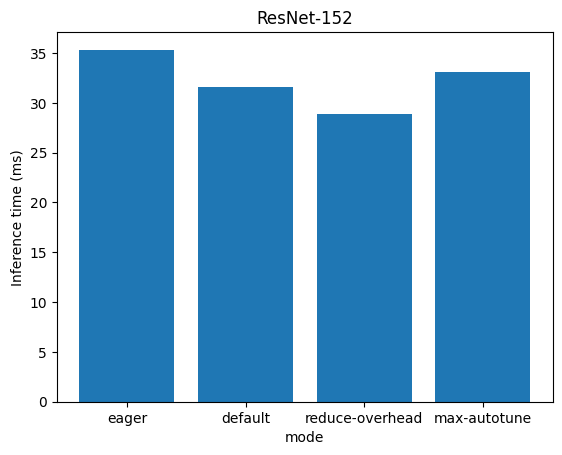

In [ ]:
import matplotlib.pyplot as plt

# Plotting the bar graph
plt.bar(mode, inference_time)
print(inference_time)
print(mode)

# Adding labels and title
plt.xlabel('mode')
plt.ylabel('Inference time (ms)')
plt.title('ResNet-152')

# Displaying the plot
plt.show()

-------------------------------------------------------------------

## FX Graphs and TorchInductor

In [ ]:
import torch

# Disable dynamic shapes for the purposes of this example
@torch.compile(dynamic=False)
def fn(x, y):
  x *= x
  x /= y
  return x + 1

# Set the logs to observe different artifacts of the compilation process
# in this case setting the guards kwarg to True will print the relevant guards
torch._logging.set_logs(guards=True)
fn(torch.ones(2, 2), torch.ones(2, 2))

# Other useful options:
# guards - display generated guards
# graph - display captured graph
# output_code - display the generated output code from inductor
# bytecode - display the rewritten bytecode for the function you are compiling
# recompiles - print which guard failed if the function has been compiled previously
torch._logging.set_logs(recompiles=True, guards=True)
fn(torch.ones(4, 2), torch.ones(4, 2))



V1024 07:23:10.498000 630 torch/_dynamo/guards.py:2314] [0/0] [__guards] GUARDS:
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] 
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] TREE_GUARD_MANAGER:
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] +- RootGuardManager
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] | +- DEFAULT_DEVICE: utils_device.CURRENT_DEVICE == None                           # _dynamo/output_graph.py:471 in init_ambient_guards
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] | +- GLOBAL_STATE: ___check_global_state()
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] | +- TORCH_FUNCTION_MODE_STACK: ___check_torch_function_mode_stack()
V1024 07:23:10.502000 630 torch/_dynamo/guards.py:2280] [0/0] [__guards] | +- GuardManager: source=L['x'], accessed_by=DictGetItemGuardAccessor(x)
V1024 07:23:10.502000 630 torch/_dynamo/guard

tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])

In [ ]:
### Handling special instances like data-dependent control flow
"""Graph break on data-dependent control flow

In this example, the program conditions on data within a tensor. This is not
tracable into one graph because of the data dependent control flow.
So, whenever such condition is encountered, the graph is broken,
data extracted from the tensor, and tracing continues afterward.


"""
import torch

@torch.compile()
def data_dep(x, y):
  if x.item() == 1: # <--- graph break here, extracting data from a tensor.
    y += 2
    x += 3
  else:
    y += 3

  return y

torch._logging.set_logs(graph_breaks=True, recompiles=True, bytecode=True)
data_dep(torch.ones(1), torch.ones(5, 5))
data_dep(torch.zeros(1), torch.ones(5, 5))

V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode] ORIGINAL BYTECODE data_dep <ipython-input-5-3d12de43402a> line 13 
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]  15           0 LOAD_FAST                0 (x)
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]               2 LOAD_METHOD              0 (item)
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]               4 CALL_METHOD              0
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]               6 LOAD_CONST               1 (1)
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]               8 COMPARE_OP               2 (==)
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]              10 POP_JUMP_IF_FALSE       16 (to 32)
V1024 07:25:16.380000 630 torch/_dynamo/convert_frame.py:683] [3/0] [__bytecode]

tensor([[4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]])

In [ ]:
"""Dynamic Shapes

Dynamic shapes automatically get enabled if the shapes of the inputs change
during a recompilation. In the output code the shapes values are passed to
the kernel to take into account this dynamism.

"""

import torch

@torch.compile()
def fn(x, y):
  return x * y + 10

torch._logging.set_logs(guards=True)
fn(torch.ones(2, 2), torch.ones(2, 2))
torch._logging.set_logs(guards=True, recompiles=True, output_code=True)
fn(torch.ones(4, 2), torch.ones(4, 2))




V1024 07:25:52.630000 630 torch/_dynamo/guards.py:2314] [5/0] [__guards] GUARDS:
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] 
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] TREE_GUARD_MANAGER:
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] +- RootGuardManager
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] | +- DEFAULT_DEVICE: utils_device.CURRENT_DEVICE == None                           # _dynamo/output_graph.py:471 in init_ambient_guards
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] | +- GLOBAL_STATE: ___check_global_state()
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] | +- TORCH_FUNCTION_MODE_STACK: ___check_torch_function_mode_stack()
V1024 07:25:52.632000 630 torch/_dynamo/guards.py:2280] [5/0] [__guards] | +- GuardManager: source=L['x'], accessed_by=DictGetItemGuardAccessor(x)
V1024 07:25:52.632000 630 torch/_dynamo/guard

tensor([[11., 11.],
        [11., 11.],
        [11., 11.],
        [11., 11.]])